In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import argparse
import contextlib
import logging
import os
import sys

import pytorch_lightning as pl
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from pytorch_lightning.utilities.rank_zero import rank_zero_only


import threestudio
from threestudio.systems.base import BaseSystem
from threestudio.utils.callbacks import (
    CodeSnapshotCallback,
    ConfigSnapshotCallback,
    CustomProgressBar,
    ProgressCallback,
)
from threestudio.utils.config import ExperimentConfig, load_config
from threestudio.utils.misc import get_rank
from threestudio.utils.typing import Optional

torch.cuda.memory._record_memory_history(enabled=True)

/home/kplanes2/venv/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/kplanes2/venv/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/kplanes2/venv/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_21m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_

In [3]:
class ColoredFilter(logging.Filter):
    """
    A logging filter to add color to certain log levels.
    """

    RESET = "\033[0m"
    RED = "\033[31m"
    GREEN = "\033[32m"
    YELLOW = "\033[33m"
    BLUE = "\033[34m"
    MAGENTA = "\033[35m"
    CYAN = "\033[36m"

    COLORS = {
        "WARNING": YELLOW,
        "INFO": GREEN,
        "DEBUG": BLUE,
        "CRITICAL": MAGENTA,
        "ERROR": RED,
    }

    RESET = "\x1b[0m"

    def __init__(self):
        super().__init__()

    def filter(self, record):
        if record.levelname in self.COLORS:
            color_start = self.COLORS[record.levelname]
            record.levelname = f"{color_start}[{record.levelname}]"
            record.msg = f"{record.msg}{self.RESET}"
        return True


In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
env_gpus_str = os.environ.get("CUDA_VISIBLE_DEVICES", None)
env_gpus = list(env_gpus_str.split(",")) if env_gpus_str else []
selected_gpus = [0]

# Always rely on CUDA_VISIBLE_DEVICES if specific GPU ID(s) are specified.
# As far as Pytorch Lightning is concerned, we always use all available GPUs
# (possibly filtered by CUDA_VISIBLE_DEVICES).
devices = -1
if len(env_gpus) > 0:
    # CUDA_VISIBLE_DEVICES was set already, e.g. within SLURM srun or higher-level script.
    n_gpus = len(env_gpus)

print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 4090


In [5]:
yaml = """name: "zero123"
exp_root_dir: "outputs"
seed: 0


data_type: "multiview-camera-datamodule"
data:
  train_downsample_resolution: 1
  eval_downsample_resolution: 1
  dataroot: "load/chair"
  camera_layout: "input"

system_type: "zero123-system"
system:
  geometry_type: "implicit-volume"
  geometry:
    radius: 2.0

    # the density initialization proposed in the DreamFusion paper
    # does not work very well
    # density_bias: "blob_dreamfusion"
    # density_activation: exp
    # density_blob_scale: 5.
    # density_blob_std: 0.2

    # use Magic3D density initialization instead
    density_bias: "blob_magic3d"
    density_activation: softplus
    density_blob_scale: 10.
    density_blob_std: 0.5

    pos_encoding_config:
      otype: KPlanes
      n_feature_count: 40
      resolutions: [256]     # each entry N in this list creates K planes with resolution N x N.
      n_dimensions: 3            # 3 => 3 planes per resolution, 4 => 6 planes per resolution
    mlp_network_config:
      otype: "VanillaMLP"
      activation: "ReLU"
      output_activation: "none"
      n_neurons: 64
      n_hidden_layers: 2

  material_type: "diffuse-with-point-light-material"
  material:
    ambient_only_steps: 0
    textureless_prob: 0.05
    albedo_activation: sigmoid

  background_type: "solid-color-background"

  renderer_type: "nerf-volume-renderer"
  renderer:
    radius: ${system.geometry.radius}
    num_samples_per_ray: 128
    return_comp_normal: ${cmaxgt0:${system.loss.lambda_normal_smooth}}
    return_normal_perturb: ${cmaxgt0:${system.loss.lambda_3d_normal_smooth}}
    grid_prune: True

  prompt_processor_type: "dummy-prompt-processor" # Zero123 doesn't use prompts
  prompt_processor:
    pretrained_model_name_or_path: ""
    prompt: ""

  ambient_ratio_min: [0, 0.1, 0.5, 400, 0.9, 401]

  loggers:
    wandb:
      enable: false
      project: "threestudio"
      name: None

  loss:
    lambda_sds: 0.1
    lambda_rgb: [100, 500., 1000., 400]
    lambda_mask: 50.
    lambda_depth: 0. # 0.05
    lambda_depth_rel: 0. # [0, 0, 0.05, 100]
    lambda_normal: 0. # [0, 0, 0.05, 100]
    lambda_normal_smooth: [100, 7.0, 5.0, 150, 10.0, 200]
    lambda_3d_normal_smooth: [100, 7.0, 5.0, 150, 10.0, 200]
    lambda_orient: 1.0
    lambda_sparsity: 0.5 # should be tweaked for every model
    lambda_opaque: 0.5
    lambda_l1_regularization: 2
    lambda_total_variation: 5

  optimizer:
    name: Adam
    args:
      lr: 0.01
      betas: [0.9, 0.99]
      eps: 1.e-8

trainer:
  max_steps: 2000
  log_every_n_steps: 1
  num_sanity_val_steps: 0
  val_check_interval: 50
  enable_progress_bar: true
  precision: 32

checkpoint:
  save_last: true # save at each validation time
  save_top_k: -1
  every_n_train_steps: ${trainer.max_steps}

"""

In [6]:

torch.cuda.memory._record_memory_history(enabled=True)

from IPython.display import Image, display
extras = {
    "tag" : "kplanes"
}

cfg: ExperimentConfig
cfg = load_config(yaml, extras, from_string=True, n_gpus=1)

# set a different seed for each device
pl.seed_everything(cfg.seed + get_rank(), workers=True)

dm = threestudio.find(cfg.data_type)(cfg.data)
system: BaseSystem = threestudio.find(cfg.system_type)(
    cfg.system, resumed=cfg.resume is not None
)
system.set_save_dir(os.path.join(cfg.trial_dir, "save"))

callbacks = []

callbacks += [
    ModelCheckpoint(
        dirpath=os.path.join(cfg.trial_dir, "ckpts"), **cfg.checkpoint
    ),
    LearningRateMonitor(logging_interval="step"),
    CodeSnapshotCallback(
        os.path.join(cfg.trial_dir, "code"), use_version=False
    )
]
callbacks += [CustomProgressBar(refresh_rate=1)]

def write_to_text(file, lines):
    with open(file, "w") as f:
        for line in lines:
            f.write(line + "\n")

loggers = []

# make tensorboard logging dir to suppress warning
rank_zero_only(
    lambda: os.makedirs(os.path.join(cfg.trial_dir, "tb_logs"), exist_ok=True)
)()
loggers += [
    TensorBoardLogger(cfg.trial_dir, name="tb_logs"),
    CSVLogger(cfg.trial_dir, name="csv_logs"),
] + system.get_loggers()


def set_system_status(system: BaseSystem, ckpt_path: Optional[str]):
    if ckpt_path is None:
        return
    ckpt = torch.load(ckpt_path, map_location="cpu")
    system.set_resume_status(ckpt["epoch"], ckpt["global_step"])

Seed set to 0


In [7]:
system.renderer.geometry.density_network.layers
next(system.renderer.geometry.encoding.encoding.planes[0][0].parameters())

Parameter containing:
tensor([[[[0.4963, 0.7682, 0.0885,  ..., 0.3538, 0.2032, 0.3151],
          [0.0044, 0.7257, 0.2599,  ..., 0.6673, 0.3561, 0.8091],
          [0.3613, 0.3136, 0.6259,  ..., 0.1497, 0.3923, 0.9338],
          ...,
          [0.3116, 0.4711, 0.3279,  ..., 0.9936, 0.4179, 0.8564],
          [0.0968, 0.9116, 0.6209,  ..., 0.0626, 0.7197, 0.1498],
          [0.8913, 0.3866, 0.0981,  ..., 0.0203, 0.4361, 0.7152]],

         [[0.0116, 0.1024, 0.2168,  ..., 0.9654, 0.4059, 0.9423],
          [0.3063, 0.1888, 0.6668,  ..., 0.7049, 0.9703, 0.2690],
          [0.7631, 0.8919, 0.8021,  ..., 0.2004, 0.1674, 0.8123],
          ...,
          [0.1035, 0.1590, 0.8475,  ..., 0.0395, 0.7795, 0.1602],
          [0.0469, 0.6368, 0.8051,  ..., 0.2926, 0.6317, 0.7222],
          [0.5140, 0.4747, 0.1036,  ..., 0.7414, 0.0800, 0.8677]],

         [[0.7223, 0.9823, 0.6629,  ..., 0.4380, 0.9402, 0.5241],
          [0.1251, 0.4093, 0.4452,  ..., 0.9649, 0.5731, 0.8785],
          [0.6563, 0

In [8]:

from torch.utils.checkpoint import checkpoint, checkpoint_sequential    

eps = 0.001
NUM_POINTS = 1 << 12
system.renderer.geometry.encoding.cuda()
system.renderer.geometry.density_network.cuda()
system.renderer.geometry.feature_network.cuda()
points = torch.randn((NUM_POINTS,3), device="cuda:0", requires_grad=True)
watermark = torch.cuda.memory_allocated(0)

mode = "CHECKPOINT"

sixteenGB = 1 << 34
samplesPerRay = 256
numRays = 256 * 256 * 2
bytesPerRay = sixteenGB / (samplesPerRay * numRays)
print(f"target bytes per ray {bytesPerRay:,}")


if mode == "CHECKPOINT":
    encoding =  checkpoint(system.renderer.geometry.encoding, points) 
    print(encoding.requires_grad)
    density = checkpoint(system.renderer.geometry.density_network.layers, encoding)
    #density = checkpoint_sequential(system.renderer.geometry.density_network.layers,1, encoding)
    #albedo = checkpoint_sequential(system.renderer.geometry.feature_network.layers,1, encoding)
    albedo = checkpoint(system.renderer.geometry.feature_network.layers, encoding)
    print(albedo.shape, albedo.requires_grad)

    #offsets = torch.as_tensor([[eps, 0.0, 0.0], [0.0, eps, 0.0], [0.0, 0.0, eps]]).to(points)
    #points_offset = (points[..., None, :] + offsets).clamp(-2,2)    
    #density_offset =   checkpoint_sequential(system.renderer.geometry.density_network.layers, 1, system.renderer.geometry.encoding(points_offset))
    #normal = -(density_offset[..., 0::1, 0] - density) / eps
else:
    # no checkpointing 20KB per point
    encoding = system.renderer.geometry.encoding(points)
    density = system.renderer.geometry.density_network(encoding)
    albedo = system.renderer.geometry.feature_network(encoding)

    offsets = torch.as_tensor(
        [[eps, 0.0, 0.0], [0.0, eps, 0.0], [0.0, 0.0, eps]]
    ).to(points)
    points_offset = (points[..., None, :] + offsets).clamp(-2,2)
    density_offset =  system.renderer.geometry.density_network(system.renderer.geometry.encoding(points_offset))
    normal = -(density_offset[..., 0::1, 0] - density) / eps

print(mode, (torch.cuda.memory_allocated(0) - watermark) / NUM_POINTS)
torch.cuda.memory._dump_snapshot("my_snapshot.pickle")
torch.cuda.memory._record_memory_history(enabled=False)



target bytes per ray 512.0
True
torch.Size([4096, 3]) True
CHECKPOINT 2256.0


/home/kplanes2/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [9]:

# Enable to see structure of training batches
if False:
    
    import math
    dm.setup("fit")
    loader = dm.train_dataloader()
    iter_loader = iter(loader)
    batch = next(iter_loader)
    
    batch_size_bytes = 0
    
    def display_batch(current, level=0):
        if level >= 2:
            return
        global batch_size_bytes
        for key,value in batch.items():
            if isinstance(value,torch.Tensor):
                print('\t' * level + f"{key}: {value.shape} size={math.prod(value.shape)}*{value.element_size()}, {value.device}")
                batch_size_bytes += math.prod(value.shape)*value.element_size()
            elif isinstance(value,dict):
                print('\t' * level + f"{key}:")
                display_batch(value, level + 1)
            else:
                print('\t' * level + f"{key}:{value}")
                
    display_batch(batch)
    print(batch_size_bytes)
    batch_size_bytes = 0
    loader.dataset.update_step(0, 400)
    iter_loader = iter(loader)
    batch = next(iter_loader)
    display_batch(batch)
    print(batch_size_bytes)

In [10]:
if False:
    datatypes = set()
    zero123_weight_bytes = 0
    for parameter in system.guidance.model.parameters():
        zero123_weight_bytes += parameter.element_size() * math.prod(parameter.shape)
        datatypes.add(parameter.dtype)
    
    print(f"{torch.cuda.memory_allocated(0):,} vs {zero123_weight_bytes:,} memory allocated for zero123 weights (datatypes: {datatypes})")
    
    torch.cuda.reset_max_memory_allocated()
    mem_watermark = torch.cuda.max_memory_allocated(0)
    BATCH_SIZE = 4
    guidance_test = torch.randn((BATCH_SIZE, 256,256,3), device="cuda:0")
    elevation = torch.randn((BATCH_SIZE,), device="cuda:0")
    azimuth = torch.randn((BATCH_SIZE,), device="cuda:0")
    camera_distances = torch.randn((BATCH_SIZE,), device="cuda:0")
    system.guidance.update_step(0,0)
    system.guidance(guidance_test, elevation,azimuth,camera_distances)
    
    mem_per_batch = (torch.cuda.max_memory_allocated(0) - mem_watermark) / BATCH_SIZE
    print(f"{mem_per_batch:,} bytes per zero123 guidance batch")


In [11]:
print(system.renderer.bbox)
type(system.renderer.estimator)

tensor([[-2., -2., -2.],
        [ 2.,  2.,  2.]])


nerfacc.estimators.occ_grid.OccGridEstimator

In [12]:
if False:
    dm.setup("fit")
    loader = dm.train_dataloader()
    iter_loader = iter(loader)
    batch = next(iter_loader)
    torch.cuda.reset_max_memory_allocated()
    mem_watermark = torch.cuda.max_memory_allocated(0)
    system.training_step(batch, 0)
    mem = (torch.cuda.max_memory_allocated(0) - mem_watermark)
    print(f"{mem} bytes for forward")

In [13]:
if False:
    torch.set_float32_matmul_precision('high')
    trainer = Trainer(
        callbacks=callbacks,
        logger=loggers,
        inference_mode=False,
        accelerator="gpu",
        devices=devices,
        **cfg.trainer,
    )
    trainer.fit(system, datamodule=dm, ckpt_path=cfg.resume)

In [14]:
print(torch.cuda.memory_allocated(0))
print(torch.cuda.memory_reserved(0))


40804352
56623104


In [15]:
system.renderer.geometry.density_network.layers

Sequential(
  (0): Linear(in_features=40, out_features=64, bias=False)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=64, out_features=64, bias=False)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=64, out_features=1, bias=False)
)

In [16]:
system.renderer.geometry.encoding

CompositeEncoding(
  (encoding): KPlanesFeatureField(
    (planes): ModuleList(
      (0): ModuleList(
        (0-2): 3 x KPlanesFeaturePlane()
      )
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [17]:
system.renderer.geometry.encoding.encoding

KPlanesFeatureField(
  (planes): ModuleList(
    (0): ModuleList(
      (0-2): 3 x KPlanesFeaturePlane()
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

In [20]:
loaded_model = torch.load("./outputs/chair/kplanes/ckpts/last-v8.ckpt")
system.load_state_dict(loaded_model["state_dict"])

print(f"{0.111111111111111111:.2}")

0.11


[(0, 1), (0, 2), (1, 2)]


<Figure size 640x480 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

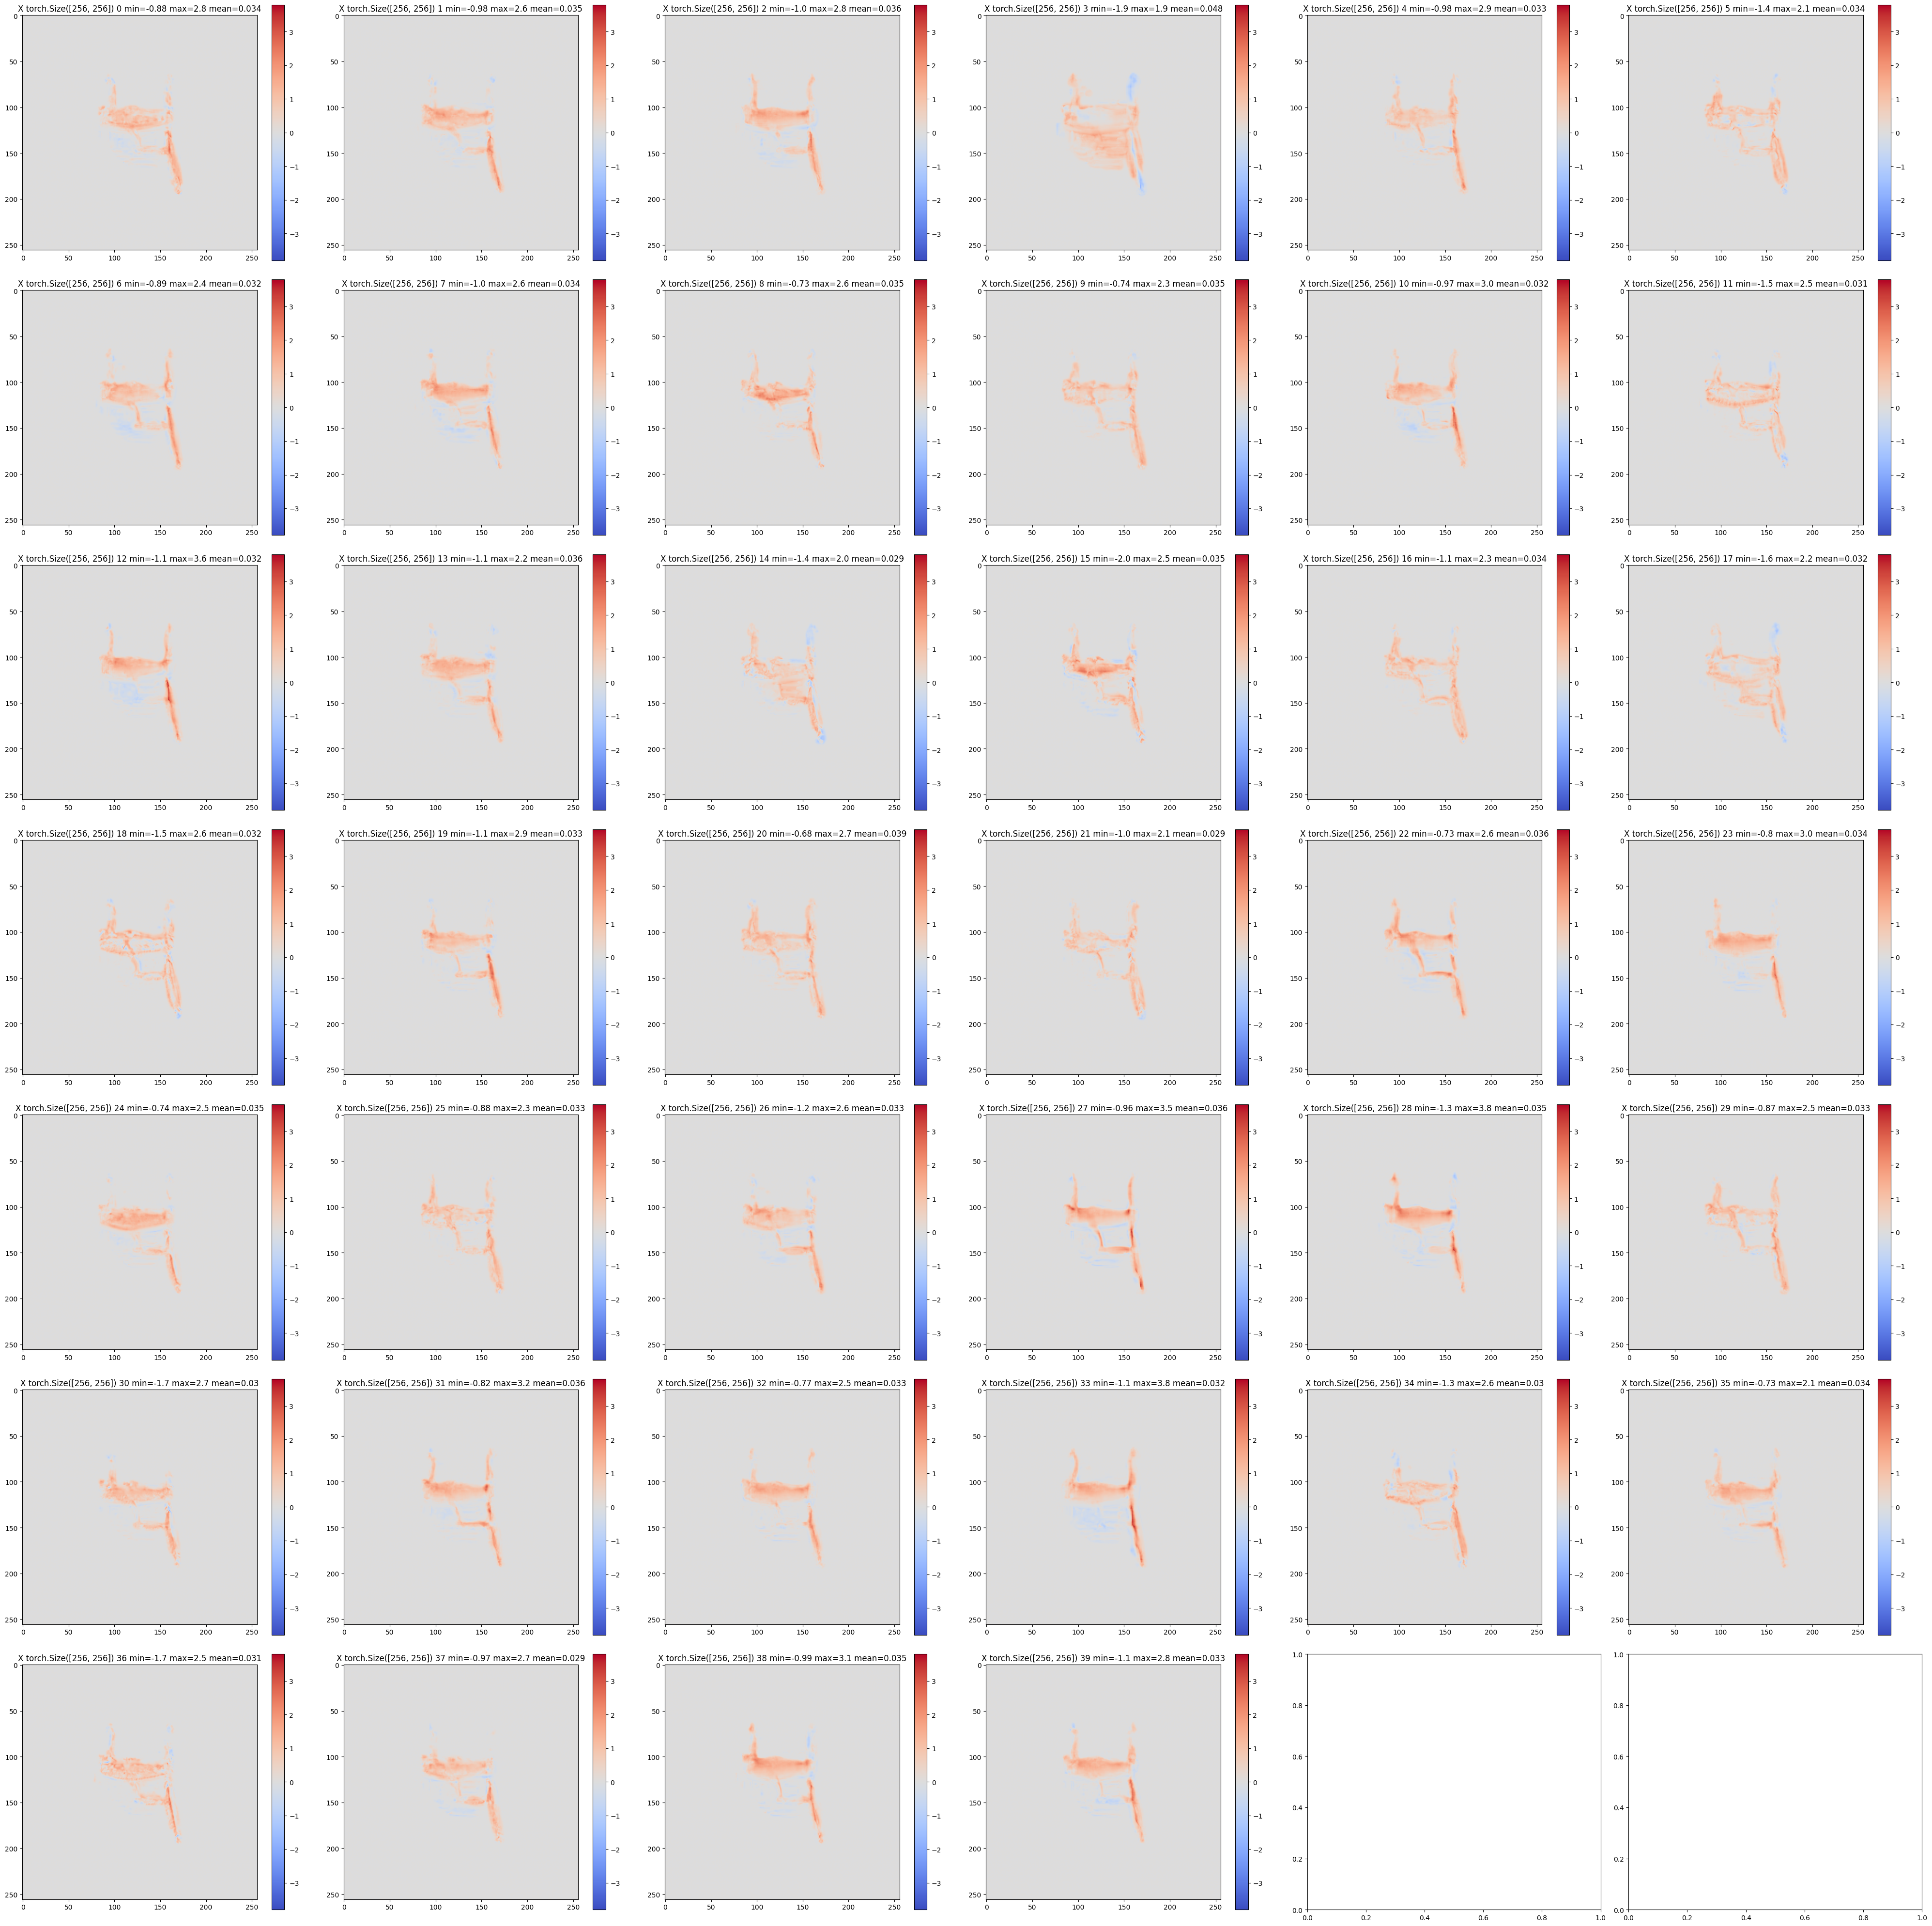

In [21]:
import itertools, math
import matplotlib.pyplot as plt
print(list(itertools.combinations(range(3),2)))

DIMENSIONS = ["Z", "Y", "X"]


global_max = 0

planes = system.geometry.encoding.encoding.planes
for resolution_idx in range(len(planes)):
    plane_list = planes[resolution_idx]
    for dimension_idx in range(len(plane_list)):
        plane = plane_list[dimension_idx].plane
        global_max = max(global_max, max(abs(plane.min()), abs(plane.max())))

def viz(t, name):
    global global_max
    plt.clf()
    C = t.shape[1]

    width = int(math.ceil(math.sqrt(C)))
    height = int(math.ceil(C / width))

    f, axarr = plt.subplots(width, height, figsize=(40,40))
    
    a = axarr.flatten()
    for idx in range(C):

        channel_data = t[:,idx].detach()

        data_min = channel_data.min()
        data_max = channel_data.max()
        data_mean = channel_data.mean()

        im = a[idx].imshow(channel_data.squeeze().cpu().numpy(), cmap="coolwarm", vmin = -global_max, vmax=global_max)
        a[idx].set_title(f"{name} {idx} min={data_min:.2} max={data_max:.2} mean={data_mean:.2}")
        plt.colorbar(im)
    plt.tight_layout()
    plt.savefig(f"{name.replace(' ', '_')}.png")
    #plt.show()

planes = system.geometry.encoding.encoding.planes
for resolution_idx in range(len(planes)):
    plane_list = planes[resolution_idx]
    for dimension_idx in range(len(plane_list)):
        plane = plane_list[dimension_idx].plane
        viz(plane, f"{DIMENSIONS[dimension_idx]} {plane.shape[-2:]}")
